<a href="https://colab.research.google.com/github/mikepuzzo/ImmRI-Hydro/blob/main/Copy_of_Battle_of_the_Neighborhoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Battle of the Neighbourhoods

This notebook is for the coursera capstone project. The focus is on Atmospheric Water Generators and finding the best locations to locate them using weather data. 

## 1,0 Import packages

In [2]:
# Google colab method for interactive dataframes
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [3]:
import numpy as np 
import pandas as pd # library for data analsysis
import json # library to handle JSON files
import io
# Geographical libraries
try:
    import geopy
except:
    !conda install -c conda-forge geopy --yes
    import geopy

   
from geopy.geocoders import Nominatim
geolocator = Nominatim(timeout=10)

geopy.geocoders.options.default_user_agent = 'my_app/banki'  # To configuration file
geopy.geocoders.options.default_timeout = 7
from geopy.extra.rate_limiter import RateLimiter
from geopy import distance

try:
  import geopandas as geopd
except:
  !pip install geopandas
  import geopandas as geopd

from shapely.geometry import Point, Polygon

# Web Scraping
import requests # library to handle requests
from bs4 import BeautifulSoup # this module helps in web scrapping.
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import folium # map rendering library
from folium.plugins import MarkerCluster
from folium import IFrame

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns # for statistical analysis
import missingno as msno
%matplotlib inline

# Import Clustering algorithms
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

print('Package load: Successful')

/usr/local/lib/python3.7/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


     |████████████████████████████████| 1.0MB 6.4MB/s 
     |████████████████████████████████| 6.5MB 8.8MB/s 
     |████████████████████████████████| 15.3MB 250kB/s 
Package load: Successful


### Functions

In [4]:
def getCoord(address):
    
    '''Collect an address and define an agent
    Return the longitude and latitute'''

    geolocator = Nominatim()
    location = geolocator.geocode(address)
    return location.latitude,  location.longitude

In [6]:
# create map of South Africa using latitude and longitude values
def LoopMap(df, add,  label , zoom_start = 7):
    
    '''df = Takes in a data frame df of children coordinates in an area  (country, state, city)
      add = Place to base map (String)
      label = location to aggregate
      zoom_start = Setting for zoom level (optional)

    Returns map of the area with coordinates as points'''
    
    lati, longi = getCoord(add)
    map_SA = folium.Map(location=[lati, longi], zoom_start=zoom_start)
#     area = 'Province'
    # add markers to map
    for lat, lng, prov in zip(df['Latitude'], df['Longitude'], df[label]):
        label = prov
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_SA)  

    return(map_SA)

## 2.0 Scrape data for List of south african provinces

South Africa has 13 provinces. Each province has unique demographic data like population, human development index and density and these are scraped from the web along with the geocordinates and stored in a database in a database. 

#### 2,1 Scrape data for list of south african provinces

Data of South african provinces are scraped from [Wikipedia](https://en.wikipedia.org/wiki/Provinces_of_South_Africa)

In [11]:
url = 'https://en.wikipedia.org/wiki/Provinces_of_South_Africa'  
tables = pd.read_html(url)

df = tables[2]
df
# df.dtypes

Province  ... Location
0              Eastern Cape  ...      NaN
1                Free State  ...      NaN
2                   Gauteng  ...      NaN
3             KwaZulu-Natal  ...      NaN
4                   Limpopo  ...      NaN
5                Mpumalanga  ...      NaN
6                North West  ...      NaN
7             Northern Cape  ...      NaN
8        Western Cape [n 2]  ...      NaN
9  Republic of South Africa  ...      NaN

[10 rows x 9 columns]

### Clean data

In [38]:
# Rename columns
clmns = list(df.columns) # List of columns to rename
new_clmns = ['Province', 
             'Top_Language',
             'Capital',
             'Largest_City',
             'Area',
             'Population_2011',
             'PopDens_2011',  # km2
            'HDI_2003']  # New names of columns

df_prov = df.loc[0:8,clmns].rename(columns = dict(zip(clmns, new_clmns)))
# Rename typos
df_prov.loc[8,'Province'] = 'Western Cape' 
df_prov.drop('Location', axis = 1, inplace = True)

df_prov.Area = df_prov.Area.str.split(expand = True)[0]
df_prov.Area = df_prov.Area.str.replace(',','')
df_prov.PopDens_2011 = df_prov.PopDens_2011.str.split('/', expand = True)[0]

df_prov['PopDens_2011'] = df_prov['PopDens_2011'].astype(float)
df_prov['Area'] = df_prov['Area'].astype(float)
df_prov = df_prov.convert_dtypes()
df_prov


Province               Top_Language  ... PopDens_2011 HDI_2003
0   Eastern Cape      iMpuma-Koloni (Xhosa)  ...         38.8     0.62
1     Free State          Freistata (Sotho)  ...         21.1     0.67
2        Gauteng               eGoli (Zulu)  ...        675.1     0.74
3  KwaZulu-Natal     iKwaZulu-Natali (Zulu)  ...        108.8     0.63
4        Limpopo   Limpopo (Northern Sotho)  ...         43.0     0.59
5     Mpumalanga        iMpumalanga (Swazi)  ...         52.8     0.65
6     North West  Bokone Bophirima (Tswana)  ...         33.5     0.61
7  Northern Cape     Noord-Kaap (Afrikaans)  ...          3.1     0.69
8   Western Cape       Wes-Kaap (Afrikaans)  ...         45.0     0.77

[9 rows x 8 columns]

Create a list of provinces 

Loop through the list of provinces to get location coordinates and add to province dataframe

In [46]:
#  Instantiate column
df_loc = pd.DataFrame(columns = ['Province', 'Latitude', 'Longitude'])
# Loop through all provinces in South africa
for prov in list(df_prov['Province']):
    address = prov + ', South Africa' # To avoid selecting wrong places
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
# Adds the coordinates of each province
    df_loc = df_loc.append({'Latitude': location.latitude,
                    'Longitude': location.longitude,
                           'Province': prov}, ignore_index=True)
#     print('The coordinates of {} is {} and {}'.format(address, longitude, latitude))
df_locs   

AttributeError: ignored

Province   Latitude  Longitude
0   Eastern Cape -32.217183  26.638640
1     Free State -28.785362  26.497893
2        Gauteng -25.936344  28.081311
3  KwaZulu-Natal -28.503833  30.887501
4        Limpopo -23.473529  29.395920
5     Mpumalanga -26.276849  30.150015
6     North West -26.134782  25.654673
7  Northern Cape -29.573402  21.205136
8   Western Cape -33.546977  20.727530

In [ ]:
add = 'South Africa'  
lati, longi = getCoord(add)
print('Lat: {} and Long: {}'.format(lati, longi))


Lat: -28.8166236 and Long: 24.991639


In [ ]:
maps = LoopMap(df = df_loc, add = 'South Africa', zoom_start = 6, label = 'Province')
maps

##  3.0 Cape Town
Cape Town is the largest city in South Africa after Johannesburg. It's one of the capitals of south Africa an a tourist center

Scrape data of all surburbs in Cape Town from [Wikipedia](https://en.wikipedia.org/wiki/List_of_Cape_Town_suburbs)

In [40]:
# Use pandas to collect all tables from the url
url = 'https://en.wikipedia.org/wiki/List_of_Cape_Town_suburbs'
# Get required tables
tables = pd.read_html(url, attrs = {'class':'wikitable'} )
df_surbs = pd.DataFrame(columns = ['Suburb', 'District'])

# Districts or Exurbs
districts = ['Atlantic Seaboard', 'Klipfontein District (Old Cape Flats)',
             'City Bowl', 'Helderberg', 'Northern Suburbs',
             'South Peninsula', 'Southern Suburbs',
             'Western Suburbs']
# Loop through tables and add column of exurb
for idx in range(len(tables)):
  tables[idx]['District'] = districts[idx] 
  tables[idx] = tables[idx][['Suburb', 'District']]
  df_surbs = df_surbs.append(tables[idx])

# Some suburb appear twice. ??
df_surbs.drop_duplicates('Suburb', inplace = True)
df_surbs.reset_index(inplace= True, drop=True)
df_surbs.to_csv('SA Provinces.csv')
df_surbs

Suburb           District
0             Bakoven  Atlantic Seaboard
1          Bantry Bay  Atlantic Seaboard
2           Camps Bay  Atlantic Seaboard
3             Clifton  Atlantic Seaboard
4            Fresnaye  Atlantic Seaboard
..                ...                ...
130     Melkbosstrand    Western Suburbs
131  Montague Gardens    Western Suburbs
132         Parklands    Western Suburbs
133        Table View    Western Suburbs
134        West Beach    Western Suburbs

[135 rows x 2 columns]

Create a list of all Suburbs in Capetown

In [45]:
# Geocode the surburbs
df_surbs['full_address'] = df_surbs.Suburb.str.split('(', n=1, expand= True)[0] + ', Cape Town, South Africa'
df_surbs['gcode'] = df_surbs.full_address.apply(geolocator.geocode)
lats = []
longs = []
for idx in range(df_surbs.shape[0]):
  if df_surbs.loc[idx,'gcode'] != None:
    lat = df_surbs.loc[idx,'gcode'].latitude
    longi = df_surbs.loc[idx,'gcode'].longitude
  else:
    lat = None
    longi = None
  lats.append(lat)
  longs.append(longi)
df_surbs['Latitude'] = lats
df_surbs['Longitude'] = longs
df_surbs.drop(columns= 'full_address', inplace= True)
df_surbs.dropna(axis=0, inplace=True)
df_surbs

Suburb           District  ...   Latitude  Longitude
0             Bakoven  Atlantic Seaboard  ... -33.960000  18.382778
1          Bantry Bay  Atlantic Seaboard  ... -33.928151  18.378970
2           Camps Bay  Atlantic Seaboard  ... -33.954774  18.381852
3             Clifton  Atlantic Seaboard  ... -33.935285  18.379070
4            Fresnaye  Atlantic Seaboard  ... -33.925194  18.387743
..                ...                ...  ...        ...        ...
130     Melkbosstrand    Western Suburbs  ... -33.722222  18.445833
131  Montague Gardens    Western Suburbs  ... -33.859750  18.522916
132         Parklands    Western Suburbs  ... -33.804562  18.509349
133        Table View    Western Suburbs  ... -33.823611  18.490278
134        West Beach    Western Suburbs  ... -33.810477  18.478969

[131 rows x 5 columns]

In [ ]:
# Create map with the neighbourhood coordinates
location = geolocator.geocode('Cape Town')
lati = location.latitude
longi = location.longitude
map_CT = folium.Map(location=[lati, longi], zoom_start=10)
for lat, lng, surb, district in zip(df_surbs['Latitude'], df_surbs['Longitude'], df_surbs['Suburb'], df_surbs['District']):
        label = surb + ', ' + district
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_CT)  

map_CT

## FourSquare Venues

Define Client ID, Secrets, Token and Version

In [52]:
CLIENT_ID = 'B3H1JSMBFGKWPLB10JP50SLDK2HWEDEXDSTMIQPQUDWJXK3Y' #  Foursquare ID
CLIENT_SECRET = 'ZIN0FLLV5HGCWZKKUFHPNQLRFYFJCPMOA4HAHUKSLRKAK0CX' #  Foursquare Secret
ACCESS_TOKEN = "HBXF3JFTMRLJXACINCLJF0YYG35TV4Y4F3FDFFBR4LM31QVS" #  FourSquare Access Token
VERSION = '20180604'

In [49]:
hood ='Three Anchor Bay'
hoodrow = df_surbs[df_surbs.Suburb==hood]
hoodrow['Latitude']

11   -33.909167
Name: Latitude, dtype: float64

In [55]:
radius = 500 # Radius around location of 500 m
LIMIT = 200  # Like SQL limit the number of values from api
# define url
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    -33.909167,
    18.395556,  
    radius, 
    LIMIT)

# Send get request
results = requests.get(url).json()
# results

In [ ]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [59]:
# Get the venues from the json result
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

name  ...        lng
0                            Coco Safar  ...  18.394490
1                      Blackheath Lodge  ...  18.397697
2                              He Sheng  ...  18.394650
3              Sea Point Promenade Park  ...  18.396296
4                             Hotel 303  ...  18.392876
5           Woolworths Three Anchor Bay  ...  18.396372
6            Ashanti Lodge - Greenpoint  ...  18.400622
7                                Clicks  ...  18.397243
8                            Woolworths  ...  18.396678
9                          Buzbey Grill  ...  18.397432
10                           Bootlegger  ...  18.396154
11                       Franky's Diner  ...  18.393034
12                     Shawarma Express  ...  18.392374
13            Venezia Ice Cream Parlour  ...  18.394080
14            Winchester Mansions Hotel  ...  18.390843
15                   Syriana Restaurant  ...  18.392881
16                     Richard's Bistro  ...  18.397223
17  Winchester Mansions Hotel Cape Town  ...  18.390712
18                             Rockpool  ...  18.393372
19                             Seapoint  ...  18.391521
20                          Empire Asia  ...  18.395710
21                  Duchess Of Wisbeach  ...  18.392946
22                      Wonderful Sushi  ...  18.392735
23                              Nando's  ...  18.394558
24       Harveys at Winchester Mansions  ...  18.390536
25                         Cafe Sofia's  ...  18.394940
26                                  KFC  ...  18.394900
27          Xiang Yuan Chinese & Sushi.  ...  18.396931
28                          Pick 'n Pay  ...  18.394331
29          Aldiwan | الديوان (Aldiwan)  ...  18.396684
30                         Andy's Sushi  ...  18.392384
31                      Rocklands Beach  ...  18.392048
32                        Paddy Malones  ...  18.396928
33                 Saul's Sushi @ Vegas  ...  18.392666
34                   Rocklands Rd. Park  ...  18.393914
35                               Clicks  ...  18.394500
36                       Atlantic Ocean  ...  18.394911
37                             7 ELEVEN  ...  18.397322
38                            DecoDance  ...  18.392576
39             Mouille Point Lighthouse  ...  18.398208
40                     Head South Lodge  ...  18.400157
41                             Studio 7  ...  18.395413

[42 rows x 4 columns]

**All hoods**

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
CT_venues = getNearbyVenues(names=df_surbs['Suburb'],
                                   latitudes=df_surbs['Latitude'],
                                   longitudes=df_surbs['Longitude'], radius = 1500
                                  )

In [ ]:
print('There are {} uniques categories.'.format(len(CT_venues['Venue Category'].unique())))

There are 223 uniques categories.


In [ ]:
pd.set_option('mode.chained_assignment', None) # Remove slice warning
venues_duplicated = CT_venues[['Venue Longitude']].duplicated(keep = False) #Get duplicated venues
dup_lat = CT_venues[venues_duplicated][['Venue Longitude']].value_counts().to_frame() # Probably needs more criteria (review)
frames = pd.DataFrame(columns=['Neighbourhood', 'Neighbourhood Latitude', 'Neighbourhood Longitude',
       'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category', 'distance'])
for idx in range(dup_lat.shape[0]): 
  mask = CT_venues[CT_venues['Venue Longitude']==dup_lat.index[idx]]
  weg = []
  for n_lat, n_long, v_lat, v_long in zip(mask['Neighbourhood Latitude'],mask['Neighbourhood Longitude'],
                                        mask['Venue Latitude'],mask['Venue Longitude']):
    v_location = (v_lat, v_long)
    n_location = (n_lat, n_long)
    dist = distance.distance(v_location, n_location).km
    weg.append(dist)
  mask['distance'] = weg
  mask = mask[mask['distance']==mask['distance'].min()]
  frames = frames.append(mask)
frames.drop(columns = 'distance', inplace = True)
CT_venues = CT_venues.drop_duplicates('Venue Longitude', keep= False)
CT_venues = CT_venues.append(frames)
# CT_venues.reset_index(inplace=True, drop=True)
CT_venues


Neighbourhood  ...        Venue Category
46          Bakoven  ...                 Hotel
48          Bakoven  ...                 Hotel
49          Bakoven  ...            Restaurant
51          Bakoven  ...                 Hotel
171       Camps Bay  ...                 Hotel
...             ...  ...                   ...
3252       Newlands  ...         Grocery Store
3215       Newlands  ...        Sandwich Place
3244       Newlands  ...  Fast Food Restaurant
2913     Heathfield  ...     Food & Drink Shop
431   Imizamo Yethu  ...         Deli / Bodega

[1844 rows x 7 columns]

In [ ]:
print('There are {} uniques categories.'.format(len(CT_venues['Venue Category'].unique())))

There are 222 uniques categories.


In [ ]:
CT_venues.loc[CT_venues['Venue Category'].str.endswith('Hotel'), 'Venue Category'] = 'Hotel'
CT_venues.loc[CT_venues['Venue Category'].str.endswith('Restaurant'), 'Venue Category'] = 'Restaurant'
CT_venues['Venue Category'].value_counts().head(10)

Restaurant       417
Hotel            106
Café             104
Coffee Shop       99
Grocery Store     70
Shopping Mall     60
Gas Station       46
Pizza Place       44
Beach             37
Burger Joint      36
Name: Venue Category, dtype: int64

## Ward GeoJson



In [ ]:
# Load geojson file from Inside Airbnb
ward_geo = geopd.read_file('http://data.insideairbnb.com/south-africa/wc/cape-town/2021-02-23/visualisations/neighbourhoods.geojson')
ward_geo.drop('neighbourhood_group', axis=1, inplace=True)
# ward_geo.head()

In [ ]:
# df_surbs['Coord'] = list(zip(df_surbs.Latitude,df_surbs.Longitude))
# df_surbs

In [ ]:
top_50 = CT_venues.groupby('Neighbourhood').Venue.count().to_frame()
top_50

Venue
Neighbourhood                               
Athlone                                   10
Atlantis                                   3
Bakoven                                   14
Bantry Bay                                20
Belhar                                     4
...                                      ...
West Beach                                21
Wetton                                     4
Woodstock (including Upper Woodstock)     23
Wynberg                                   12
Zonnebloem (District Six)                 21

[127 rows x 1 columns]

Chlorpeth map of venue counts

Water treatment plants in cape town

In [ ]:
CT_wtp = pd.read_excel('CT_WTP.xlsx')
CT_wtp['Longitude'] = CT_wtp['Coordinates'].str.split(', ', expand = True)[1]
CT_wtp['Longitude'] = CT_wtp['Longitude'].apply(lambda x: float(x))
CT_wtp['Latitude'] = CT_wtp['Coordinates'].str.split(', ', expand = True)[0]
CT_wtp['Latitude'] = CT_wtp['Latitude'].apply(lambda x: float(x))
CT_wtp.drop('Coordinates', inplace=True, axis = 1)
CT_wtp.dtypes

Water treatment plant                    object
Capacity (Ml/day)                         int64
Treatment process and chemicals used     object
Water source                             object
Constructed                             float64
Longitude                               float64
Latitude                                float64
dtype: object

In [ ]:
lati, longi = getCoord('Cape Town')
map_SA = folium.Map(location=[lati, longi], zoom_start=10)
#     area = 'Province'
    # add markers to map
for lat, lng, prov in zip(CT_wtp['Latitude'], CT_wtp['Longitude'], CT_wtp['Water treatment plant']):
  label = prov
  label = folium.Popup(label, parse_html=True)
  folium.CircleMarker([lat, lng],radius=7,
                      popup=label,
                      color='red',
                      fill=True,
                      fill_color='#3186cc',
                      fill_opacity=0.7,
                      parse_html=False).add_to(map_SA)

In [ ]:
map_SA

In [ ]:
import pandas as pd
from scipy.spatial.distance import cdist



def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

def match_value(df, col1, x, col2):
    """ Match value x from col1 row to value in col2. """
    return df[df[col1] == x][col2].values[0]

CT_merged['point'] = [(x, y) for x,y in zip(CT_merged['Latitude'], CT_merged['Longitude'])]
CT_wtp['point'] = [(x, y) for x,y in zip(CT_wtp['Latitude'], CT_wtp['Longitude'])]

CT_merged['closest'] = [closest_point(x, list(CT_wtp['point'])) for x in CT_merged['point']]
CT_merged['WTP'] = [match_value(CT_wtp, 'point', x, 'Water treatment plant') for x in CT_merged['closest']]

CT_merged.drop(columns= ['point', 'closest'], inplace = True)

## K-Means Clustering

Create one-hot categories according to unique venue categories

In [ ]:
# one hot encoding
def OneHot(venues):
    CT_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

    # add neighborhood column back to dataframe
    CT_onehot['Suburbs'] = CT_venues['Neighbourhood'] 

    # move neighborhood column to the first column
    fixed_columns = [CT_onehot.columns[-1]] + list(CT_onehot.columns[:-1])
    CT_onehot = CT_onehot[fixed_columns]

    print('Original Shape: {}'.format(CT_onehot.shape))
    
    CT_grouped = CT_onehot.groupby('Suburbs').mean().reset_index()
    print('Grouped Shape: {}'.format(CT_grouped.shape))

    return CT_grouped

Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [ ]:
CT_grouped = OneHot(venues = CT_venues)
CT_grouped.head()
CT_grouped['Hotel'].sum()

Original Shape: (1844, 190)
Grouped Shape: (127, 190)


5.725303792216363

In [ ]:
num_top_venues = 5

for hood in CT_grouped['Suburbs']:
    print("----"+hood+"----")
    temp = CT_grouped[CT_grouped['Suburbs'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Athlone----
                 venue  freq
0           Restaurant   0.2
1               Bakery   0.1
2  Fried Chicken Joint   0.1
3        Shopping Mall   0.1
4              Stadium   0.1


----Atlantis----
                 venue  freq
0         Soccer Field  0.33
1    Convenience Store  0.33
2  Fried Chicken Joint  0.33
3      Nature Preserve  0.00
4  Monument / Landmark  0.00


----Bakoven----
             venue  freq
0            Hotel  0.43
1  Bed & Breakfast  0.14
2            Beach  0.14
3       Steakhouse  0.07
4      Coffee Shop  0.07


----Bantry Bay----
           venue  freq
0          Hotel  0.30
1     Restaurant  0.15
2  Deli / Bodega  0.05
3            Bar  0.05
4        Dog Run  0.05


----Belhar----
                        venue  freq
0               Deli / Bodega  0.25
1               Women's Store  0.25
2  Construction & Landscaping  0.25
3            Basketball Court  0.25
4                Noodle House  0.00


----Bellville----
            venue  freq
0      Restau

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
def CommonVenue(df = CT_grouped):
    None
    indicators = ['st', 'nd', 'rd']
    # create columns according to number of top venues
    columns = df.columns[0]
    columns = [df.columns[0]]
    
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))
            
    # create a new dataframe
    subs_venues_sorted = pd.DataFrame(columns=columns)
    subs_venues_sorted[subs_venues_sorted.columns[0]] = df[df.columns[0]]

    for ind in np.arange(df.shape[0]):
        subs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df.iloc[ind, :], num_top_venues)
    return subs_venues_sorted

subs_venues_sorted = CommonVenue(df = CT_grouped)

In [ ]:
subs_venues_sorted

Suburbs  ...  5th Most Common Venue
0                                  Athlone  ...           Burger Joint
1                                 Atlantis  ...            Flea Market
2                                  Bakoven  ...          Grocery Store
3                               Bantry Bay  ...                  Beach
4                                   Belhar  ...                    Zoo
..                                     ...  ...                    ...
122                             West Beach  ...            Coffee Shop
123                                 Wetton  ...                    Zoo
124  Woodstock (including Upper Woodstock)  ...  Outdoors & Recreation
125                                Wynberg  ...  Performing Arts Venue
126              Zonnebloem (District Six)  ...         History Museum

[127 rows x 6 columns]

Find the optimum number of clusters using the Elbow method

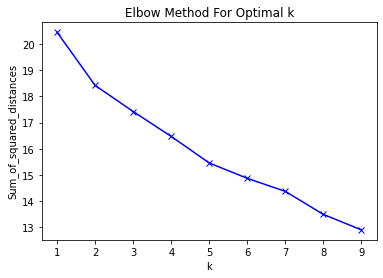

In [ ]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(CT_grouped.drop('Suburbs', 1))
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [ ]:
# set number of clusters
k = 2

# Drop irrelevant data
CT_grouped_clustering = CT_grouped.drop('Suburbs', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(CT_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:100]

# Create dist plot

array([0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int32)

Create a new dataframe that includes the top 10 venues for each neighborhood as well as their clusters.


In [ ]:
# add clustering labels
try:
    subs_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
except:
     subs_venues_sorted.drop(columns='Cluster Labels', axis=1, inplace=True)
     subs_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
    
CT_merged = df_surbs

# merge CT_grouped with CT_data to add latitude/longitude for each neighborhood
CT_merged = CT_merged.join(subs_venues_sorted.set_index('Suburbs'), on='Suburb')
print('Old size: {}'.format(CT_merged.shape))

# Drop NaN and convert cluster to int
CT_merged = CT_merged.dropna(axis = 0).reset_index(drop=True)
CT_merged['Cluster Labels']= CT_merged['Cluster Labels'].astype(int)
CT_merged


Old size: (130, 11)


Suburb  ... 5th Most Common Venue
0             Bakoven  ...         Grocery Store
1          Bantry Bay  ...                 Beach
2           Camps Bay  ...        Ice Cream Shop
3             Clifton  ...                 Hotel
4            Fresnaye  ...                  Café
..                ...  ...                   ...
122     Melkbosstrand  ...                 Hotel
123  Montague Gardens  ...               Stadium
124         Parklands  ...                Bakery
125        Table View  ...           Gas Station
126        West Beach  ...           Coffee Shop

[127 rows x 11 columns]

In [ ]:
CT_merged['Cluster Labels'].value_counts()

0    80
1    47
Name: Cluster Labels, dtype: int64

In [ ]:
# create map
def ClusterMap(df , add , zoom_start, area , k):
    
    lati, longi = getCoord(add)
    map_ = folium.Map(location=[lati, longi], zoom_start=zoom_start)
#     map_ = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
    x = np.arange(k)
    ys = [i + x + (i*x)**2 for i in range(k)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(df['Latitude'], df['Longitude'], df['Suburb'], df['Cluster Labels']):
        label = folium.Popup(str(poi) + ' : Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=6,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.5).add_to(map_)

    return(map_)

In [ ]:
ClusterMap(df = CT_merged, add = 'Cape Town', zoom_start = 11, area = 'Suburbs', k = k)

### Examine clusters

#### Cluster 1

Red coloured: Outskirts

In [ ]:
CT_merged.loc[CT_merged['Cluster Labels'] == 0, CT_merged.columns[[0] + list(range(4, CT_merged.shape[1]))]]


Suburb  Longitude  ...  4th Most Common Venue 5th Most Common Venue
0          Bakoven  18.382778  ...            Coffee Shop         Grocery Store
1       Bantry Bay  18.378970  ...                    Bar                 Beach
2        Camps Bay  18.381852  ...                   Café        Ice Cream Shop
4         Fresnaye  18.387743  ...                  Hotel                  Café
5      Green Point  18.405968  ...                  Hotel        Ice Cream Shop
..             ...        ...  ...                    ...                   ...
121        Darling  18.422277  ...                Theater                 Hotel
122  Melkbosstrand  18.445833  ...            Pizza Place                 Hotel
124      Parklands  18.509349  ...             Food Truck                Bakery
125     Table View  18.490278  ...          Shopping Mall           Gas Station
126     West Beach  18.478969  ...                   Café           Coffee Shop

[80 rows x 8 columns]

In [ ]:
CT_merged.loc[CT_merged['Cluster Labels'] == 1, CT_merged.columns[[0] + list(range(4, CT_merged.shape[1]))]]

## DBSCAN()

In [ ]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
# sklearn.utils.check_random_state(1000)

Clus_dataSet = CT_venues[['Venue Longitude','Venue Latitude']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.5, min_samples=200).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
CT_venues["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# A sample of clusters
CT_venues["Clus_Db"].value_counts()

 0    1146
-1     698
Name: Clus_Db, dtype: int64

### Dbscan for Surburbs

In [ ]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
# sklearn.utils.check_random_state(1000)

Clus_dataSet = df_surbs[['Longitude','Latitude']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.85, min_samples=50).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
df_surbs["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# A sample of clusters
labels

array([ 0, -1,  0, -1, -1,  0, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0, -1,
        0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0, -1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1,
        0, -1, -1, -1,  0,  0, -1, -1, -1,  0,  0,  0,  0, -1, -1, -1,  0,
        0,  0, -1, -1, -1,  0,  0, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1,
       -1, -1, -1,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1, -1,  0, -1, -1,  0, -1, -1, -1])

### Maps

In [ ]:
# create map
k = 2
lati, longi = getCoord('Cape Town')
map_ = folium.Map(location=[lati, longi], zoom_start=10)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(CT_venues['Venue Latitude'], CT_venues['Venue Longitude'], CT_venues['Neighbourhood'], CT_venues['Clus_Db']):
  label = folium.Popup(str(poi) + ' : Cluster ' + str(cluster), parse_html=True)
  folium.CircleMarker(
      [lat, lon],
      radius=4,
      popup=label,color=rainbow[cluster-1],
      fill=True,fill_color=rainbow[cluster-1],
      fill_opacity=0.5).add_to(map_)

map_

In [ ]:
CT_venues.to_csv('CT_venues.csv')
CT_wtp.to_csv('CT_wtp.csv')
CT_merged.to_csv('CT_merged.csv')